In [1]:
# Core Libraries
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.transforms import v2
#import seaborn as sns

# pytorch models
import pytorch_lightning as L
import torch.nn as nn
import torch
from torchvision import models
from model.model_v1 import *

# dataset imports
from torch.utils.data import Dataset, DataLoader
from dataset_loader import *

# Scikit Learn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix


# Import for the plots.
import matplotlib.pyplot as plt
from IPython import display

In [3]:
class LossTracker(L.Callback):
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.val_acc = []

    #def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
    def on_train_epoch_end(self, trainer, pl_module):
        loss = trainer.callback_metrics.get("train_loss").cpu()
        self.train_loss.append(loss)
        self.plot()

    #def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
    def on_validation_epoch_end(self, trainer, pl_module):
        loss = trainer.callback_metrics.get("val_loss")
        if loss is None:
            return
        loss = loss.cpu()
        acc = trainer.callback_metrics.get("val_acc").cpu()
        self.val_loss.append(loss)
        self.val_acc.append(acc)

    def plot(self):
        # Clear ouput.
        display.clear_output(wait=True)

        fig, axes = plt.subplots(1, 2, figsize=(20, 4))
        
        # Plot loss
        axes[0].plot(self.train_loss, label="Train loss")
        axes[0].plot(self.val_loss[1:], label="Validation loss")
        axes[0].set_xlabel("Iterations")
        axes[0].set_ylabel("Loss")

        # Plot accuracy
        axes[1].plot(self.val_acc[1:], label="Validation accuracy", color="green")
        axes[1].set_xlabel("Iterations")
        axes[1].set_ylabel("Accuracy")

        for ax in axes:
            ax.legend()
            ax.grid(True)
        
        plt.tight_layout()
        plt.show()
        plt.close()

In [4]:
# Setting the model.
model = ResNetFineTuner(num_classes=4, lr=1e-4, freeze_backbone=True)

/usr/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


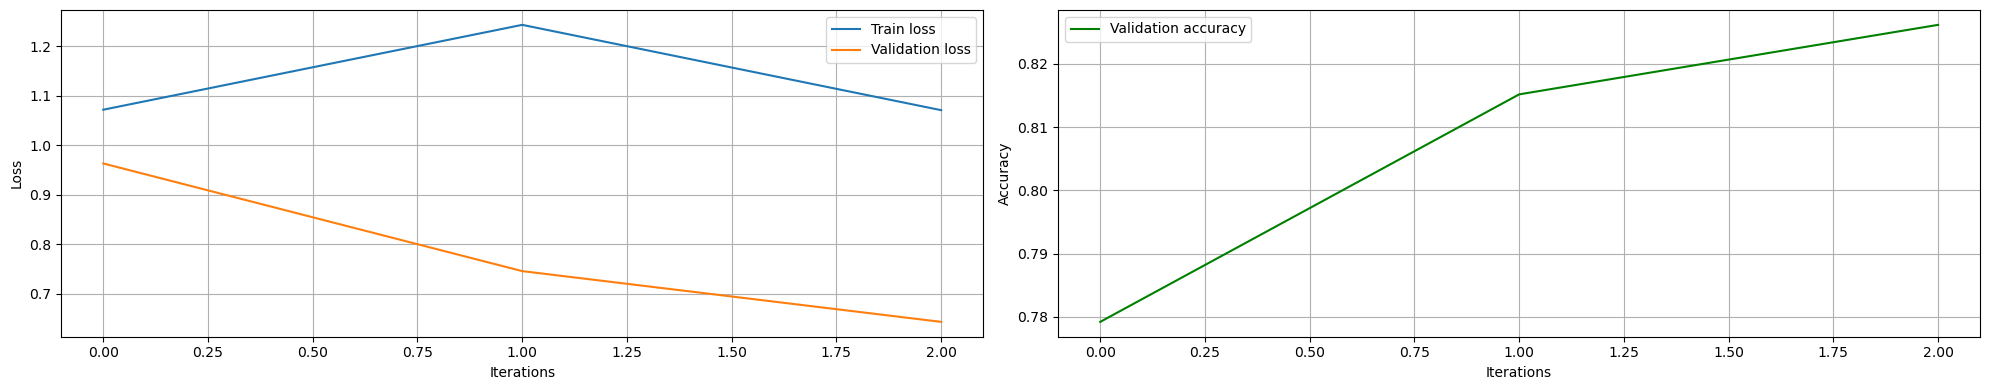

Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:05<00:00, 23.96it/s, v_num=26, val_loss=0.644, val_acc=0.826]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:05<00:00, 23.45it/s, v_num=26, val_loss=0.644, val_acc=0.826]


In [6]:
# Importing the dataset.
data_path = "data"

# Define the image size.
image_size = 224

# Define train set and test set transformations.
train_transform = v2.Compose([
    v2.Resize((image_size, image_size), antialias=True),                    
    v2.RandomHorizontalFlip(p=0.5),                           
    v2.RandomRotation(degrees=10),                             
    v2.RandomAffine(degrees=0, scale=(0.9, 1.1)),              
    #v2.ToDtype(torch.float32, scale=True),                    
    #v2.Normalize(mean=[0.485, 0.456, 0.406],                  
    #             std=[0.229, 0.224, 0.225]),
    v2.ToTensor(), 
    v2.ToDtype(torch.float32, scale=True)
])

test_transform = v2.Compose([
    v2.Resize((image_size, image_size), antialias=True),                    
    v2.ToTensor(), 
    v2.ToDtype(torch.float32, scale=True)
])

# Define the datamodule.
dm = BRISCDataModule(
    data_dir=data_path,
    batch_size=32,
    train_transform=train_transform,
    test_transform=test_transform,
    num_workers=9
)

# Define the loss tracker callback.
loss_tracker = LossTracker()

# Define the trainer.
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=3,
    callbacks=[loss_tracker]
)
trainer.fit(model, dm)

In [ ]:
print(len(loss_tracker.train_loss))
print(len(loss_tracker.val_acc))
print(len(loss_tracker.val_loss))

print(loss_tracker.train_loss)
print(loss_tracker.val_acc)
print(loss_tracker.val_loss)